In [9]:
import pandas as pd

# Define file paths
ad_sales_path = 'dataset/Ad_Sales_and_Metrics.csv'
total_sales_path = 'dataset/Product-Level_Total_Sales_and_Metrics.csv'
eligibility_path = 'dataset/Product-Level_Eligibility_Table.csv'

In [10]:
df_ad_sales = pd.read_csv(ad_sales_path)
df_total_sales = pd.read_csv(total_sales_path)
df_eligibility = pd.read_csv(eligibility_path)

print("--- Datasets loaded successfully! ---")

--- Datasets loaded successfully! ---


In [11]:
print("\n--- Ad Sales Data Analysis ---")
print("Info:")
df_ad_sales.info()
print("\nFirst 5 Rows:")
print(df_ad_sales.head())



--- Ad Sales Data Analysis ---
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3696 entries, 0 to 3695
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3696 non-null   object 
 1   item_id      3696 non-null   int64  
 2   ad_sales     3696 non-null   float64
 3   impressions  3696 non-null   int64  
 4   ad_spend     3696 non-null   float64
 5   clicks       3696 non-null   int64  
 6   units_sold   3696 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 202.3+ KB

First 5 Rows:
         date  item_id  ad_sales  impressions  ad_spend  clicks  units_sold
0  2025-06-01        0    332.96         1963     16.87       8           3
1  2025-06-01        1      0.00         1764     20.39      11           0
2  2025-06-01        2     95.99          169      0.48       0           1
3  2025-06-01        3   1001.93         6943     75.69      31           9
4  2025-06-01      

In [12]:
print("\n--- Total Sales Data Analysis ---")
print("Info:")
df_total_sales.info()
print("\nFirst 5 Rows:")
print(df_total_sales.head())



--- Total Sales Data Analysis ---
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 702 non-null    object 
 1   item_id              702 non-null    int64  
 2   total_sales          702 non-null    float64
 3   total_units_ordered  702 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 22.1+ KB

First 5 Rows:
         date  item_id  total_sales  total_units_ordered
0  2025-06-01        0       309.99                    1
1  2025-06-01        3       338.00                    2
2  2025-06-01        4       617.99                    3
3  2025-06-01        9       219.00                    1
4  2025-06-01       12       534.00                    3


In [13]:
print("\n--- Product Eligibility Data Analysis ---")
print("Info:")
df_eligibility.info()
print("\nFirst 5 Rows:")
print(df_eligibility.head())


--- Product Eligibility Data Analysis ---
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4381 entries, 0 to 4380
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   eligibility_datetime_utc  4381 non-null   object
 1   item_id                   4381 non-null   int64 
 2   eligibility               4381 non-null   bool  
 3   message                   636 non-null    object
dtypes: bool(1), int64(1), object(2)
memory usage: 107.1+ KB

First 5 Rows:
  eligibility_datetime_utc  item_id  eligibility  \
0       2025-06-04 8:50:07       29        False   
1       2025-06-04 8:50:07      270         True   
2       2025-06-04 8:50:07       31         True   
3       2025-06-04 8:50:07       26         True   
4       2025-06-04 8:50:07       25         True   

                                             message  
0  This product's cost to Amazon does not allow u...  
1                     

In [14]:
# 1.1 Datetime coercion
for df, name in zip([df_total_sales, df_ad_sales, df_eligibility],
                    ['total_sales','ad_sales','eligibility']):
    col = 'date' if 'date' in df.columns else 'eligibility_datetime_utc'
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"{name}: bad dates = {df[col].isna().sum()}")

# 1.2 Dtypes
display(df_total_sales.dtypes, df_ad_sales.dtypes, df_eligibility.dtypes)



total_sales: bad dates = 0
ad_sales: bad dates = 0
eligibility: bad dates = 0


date                   datetime64[ns]
item_id                         int64
total_sales                   float64
total_units_ordered             int64
dtype: object

date           datetime64[ns]
item_id                 int64
ad_sales              float64
impressions             int64
ad_spend              float64
clicks                  int64
units_sold              int64
dtype: object

eligibility_datetime_utc    datetime64[ns]
item_id                              int64
eligibility                           bool
message                             object
dtype: object

In [15]:
# 1.3 Duplicates
for df,name in [(df_total_sales,'total'),(df_ad_sales,'ad'),(df_eligibility,'eligibility')]:
    dup = df.duplicated().sum()
    if dup:
        print(f"{name} has {dup} dups → dropping")
        df.drop_duplicates(inplace=True)

In [16]:
# 2.1 Sales universe
total_sales_usd = df_total_sales['total_sales'].sum()
print("Total Sales $", total_sales_usd)

Total Sales $ 1004904.56


In [17]:
# 2.2 Ad universe
total_ad_spend = df_ad_sales['ad_spend'].sum()
total_ad_revenue = df_ad_sales['ad_sales'].sum()
roas = total_ad_revenue / total_ad_spend
print("RoAS", round(roas,2))



RoAS 7.92


In [20]:
# 2.3 CPC winner which product had the highest CPC (Cost Per Click) 
valid = df_ad_sales[df_ad_sales['clicks'] > 0]
top_cpc = valid.loc[valid['ad_spend'].div(valid['clicks']).idxmax()]
print("Highest CPC item_id", top_cpc['item_id'],
      "CPC $", round(top_cpc['ad_spend'] / top_cpc['clicks'], 2))

Highest CPC item_id 22 CPC $ 10.21


In [19]:
# Daily KPI dataframe (needed for charts & streaming demo)
kpis = (df_ad_sales
        .groupby('date')
        .agg(spend=('ad_spend','sum'),
             revenue=('ad_sales','sum'),
             clicks=('clicks','sum'),
             units=('units_sold','sum'))
        .assign(cpc = lambda x: x['spend']/x['clicks'],
                roas = lambda x: x['revenue']/x['spend'])
        .reset_index())
kpis.head()

,date,spend,revenue,clicks,units,cpc,roas
0,2025-06-01,3336.36,35500.25,2247,328,1.484806,10.640414
1,2025-06-02,3666.69,38854.82,2430,329,1.508926,10.596702
2,2025-06-03,4073.99,25980.76,2596,237,1.569334,6.377227
3,2025-06-04,3477.09,27791.60,2240,219,1.552272,7.992776
4,2025-06-05,2875.91,23431.55,1870,208,1.537920,8.147525


In [22]:
# 4.1 Bring eligibility flag into ad_sales
df_ad_sales = df_ad_sales.merge(
    df_eligibility[['item_id','eligibility']].drop_duplicates(),
    on='item_id', how='left')

# 4.2 Bring total_sales into ad_sales (if you want RoAS per item)
df_ad_sales = df_ad_sales.merge(
    df_total_sales[['item_id','total_sales','total_units_ordered']],
    on='item_id', how='left', suffixes=('','_organic'))
print("Post-merge nulls:", df_ad_sales.isna().sum())

Post-merge nulls: date                      0
item_id                   0
ad_sales                  0
impressions               0
ad_spend                  0
clicks                    0
units_sold                0
eligibility               0
total_sales            2520
total_units_ordered    2520
dtype: int64


In [23]:
# Save to SQLite so your Day-1 ingestion script is already perfect
import sqlite3, os
os.makedirs('data/processed', exist_ok=True)
with sqlite3.connect('data/processed/ecom.db') as conn:
    df_total_sales.to_sql('total_sales', conn, index=False, if_exists='replace')
    df_ad_sales.to_sql('ad_sales', conn, index=False, if_exists='replace')
    df_eligibility.to_sql('eligibility', conn, index=False, if_exists='replace')
    kpis.to_sql('daily_kpis', conn, index=False, if_exists='replace')
print("✅ Cleaned tables written to ecom.db")

✅ Cleaned tables written to ecom.db


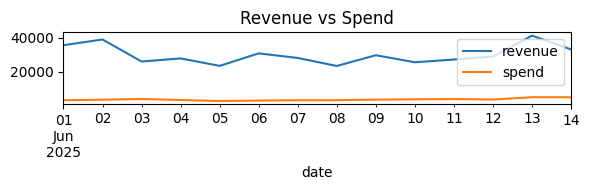

In [25]:
import matplotlib.pyplot as plt
kpis.set_index('date')[['revenue','spend']].plot(figsize=(6,2), title='Revenue vs Spend')
plt.tight_layout(); plt.savefig('data/processed/revenue_vs_spend.png')

In [26]:
import sqlite3
with sqlite3.connect('data/processed/ecom.db') as conn:
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print("Tables inside ecom.db:", [t[0] for t in cursor.fetchall()])

Tables inside ecom.db: ['total_sales', 'ad_sales', 'eligibility', 'daily_kpis']
